#### _Speech Processing Labs: SIGNALS 1: Digital Signals: Sampling and Superposition_

In [15]:
## Run this first!
%matplotlib inline
import sys
import matplotlib.pyplot as plt
import numpy as np

import cmath
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.style.use('ggplot')

from dspMisc import *

 
# Digital Signals: Sampling and Superposition

### Learning Outcomes
* Understand how we can approximate a sine wave with a specific frequency, given a specific sampling rate
* Understand how sampling rate limits the frequencies of sinusoids we can describe with discrete sequences
* Explain when aliasing will occur and how this relates the sampling rate and the Nyquist frequency.
* Observe how compound waveforms can be described as a linear combination of complex sinusoids ('superposition')

### Background
* Topic Videos: Digital Signal, Short Term Analysis, Series Expansion
* [Interpreting the discrete fourier transform](./signals-1-1-interpreting-the-discrete-fourier-transform.ipynb)

#### Extra background (extension material)
* [Digital Signals: Sinusoids and Complex Numbers](./signals-1-2a-digital-signals-complex-numbers.ipynb)


## 1 Introduction

In the class videos, you've seen that sound waves are changes in air pressure (amplitude) over time. In the notebook [interpreting the discrete fourier transform](./signals-1-1-interpreting-the-discrete-fourier-transform.ipynb), we saw that we can 
decompose complex sound waves into 'pure tone' frequency components (sinusoids). We also saw that the output of the DFT was actually a sequence of complex numbers! In this notebook, we'll give a bit more background on the relationship 
between complex numbers and sinusoids, and why it's useful to characterise sinusoids in the complex plane. 

## 2 Complex Sinusoids: tl;dr

At this point, we should say that you can get a conceptual understanding of digital signal processing concepts without going through _all_ the math. We certainly won't be examining your knowledge of complex numbers or geometry in this class.  Of course, if you want to go further in understanding digital signal processing then you will have to learn a bit more about complex numbers, algebra, calculus and geometry than we'll touch upon here.

However, right now the main point that we'd like you to take away from this notebook is that we can conveniently represent periodic functions, like sine waves, in terms of **complex sinusoids**: basically what shown on the left hand side of the following gif:

![Complex sinusoid to sine wave gif](../fig/phasor.gif)

You can think of the complex sinusoid (left) as an analogue clockface with one moving hand. On the right hand side is one period of a 'pure tone' (real) sinusoid, sin(t).   

Now, we can think of every movement of the 'clockhand' (a complex number which we can represent as a **2D vector**) as a step in time on the sinusoid graph: at every time step the 'clockhand' vector rotates by some angle. If you follow the blue dots on both graphs, you should be able to see that the amplitude of the sinusoid matches the height of the vector at each time step. 

This gives us a different way of viewing the periodicity of $\sin(t)$.  The sinusoid starts to repeat itself when the vector has done one full circle. So, rather than drawing out an infinite time vs amplitude graph, we can capture the behaviour of this periodic function in terms rotations with respect to this finite circle. 

So, what's the connection with complex numbers?  Well, that blue dot on  actually represents a complex number, and the dimensions of that graph are actually the **real** (horizontal) and **imaginary** (vertical) parts of that complex number. That is, a complex number of the form $a + jb$, where $a$ is the real part and $b$ is the imaginary part.  Quite conveniently, we can also express complex numbers in terms of a **magnitude** or radius $r$ (length of the clockhand) and a **phase angle** $\theta$ (angle of rotation from the point (1,0)) and an exponential.  So, we can write each point that the rotation hits in the form $re^{j\theta}$.  This will be familiar if you've had a look at the DFT formulae. 

This relationship with complex numbers basically allows us to describe complicated periodic waveforms in terms of combinations of 'pure tone' sinusoids.  It turns out that maths for this works very elegantly using the complex number based representation. 

The basic things you need to know are:

* A **sinusoid** (time vs amplitude, i.e. in the **time domain**) can be described in terms of a vector rotating around a circle
* That rotating vector (i.e., 'clockhand') is described by a complex number $re^{j\theta}$
* $re^{j\theta}$ is a point on a circle centered at (0,0) with radius  $r$, $\theta$ degrees rotated from $(r,0)$ on the 2D plane. 
    * the **magnitude** $r$ tells us what the peak amplitude of the corresponding sine wave is
    * the **phase angle** $\theta$ tells us how far around the circle the rotation has gone:
      * zero degrees (0 radians) corresponds to the point (r,0), while 90 degrees ($\pi/2$ radians) corresponds to the point (0,r)
* The vertical projection of the vector (onto the y-axis) corresponds to the amplitude of a **sine wave** $\sin(\theta)$ 
* The horizontal projection of the vector (onto the x-axis) corresponds to the amplitude of a **cosine wave** $\cos(\theta)$ 
* The **period** of these sine and cosine waves is the same as the time it takes to make one full circle of the complex sinusoid (in seconds). As such the **frequency** of the sine and cosine waves is the same as the frequency with which the complex sinusoid makes a full cycle (in cycles/second = Hertz). 

If you take the maths on faith, you can see all of this just from the gif above. You'll probably notice in most phonetics text books, if they show this at all, they will just show the rotating vector without any of the details. 

If you want to know more about how this works, you can find a quick tour of these concepts in the (extension) notebook on [Sinusoids and Complex Numbers](./sp-m1-2-digital-signals-complex-numbers).  But it's fine if you don't get all the details right now.  In fact, if you get the intuition behind from the complex sinusoid/sine wave relationship above, it's fine to move on now to the rest of the content in this notebook. 

## Changing the frequency of a sinusoid

So, we think of sine (and cosine) waves in terms of taking steps around a circle in the 2D (complex) plane.  Each of these 'steps' was represented by a complex number, $re^{j\theta}$ where the magnitude $r$ tells you the radius of the circle, and the phase angle $\theta$ tells you how far around the circle you are. When $\theta = 0$, means you are at the point (r,0), while $\theta = 90$ degrees means you are at the point (0,r).  There are 360 degrees (or 2$\pi$ radians) makes a complete cycle, i.e. when $\theta = 360$ degrees, you end up back at (r,0).

<div class="alert alert-success">
    It's often easier to deal with angles measured in <strong>radians</strong> rather than <strong>degrees</strong>.  The main thing to note is that:
    $$2\pi \text{ radians} = 360 \text{ degrees, i.e. 1 full circle }$$
Again, it may not seem obvious why we should want to use radians instead of the more familiar degrees.  The reason is that it makes dividing up a circle really nice and neat and so ends up making calculations much easier in the long run!
</div>

So that describes a generic sinusoid, e.g. $\sin(\theta)$, but now you might ask yourself how do we generate a generate a sine wave with a specific frequency $f$ Herzt (Hz=cycles/second)? 

Let's take a concrete example, if we want a sinusoid with a frequency of $f=10$ Hz, that means:
* **Frequency:** we need to complete 10 full cycles (i.e. 360 degree rotation) in 1 second.  
* **Period:** So, we have to complete 1 full cycle every 1/10 seconds (i.e. the period of this sinusoid $T=0.1$ seconds). 
* **Angular velocity:** So, the rotating vector has to rotate at a speed of $2\pi/0.1 = 20\pi$ radians per second

So if we take $t$ to represent time, a sine wave with frequency 10 Hz has the form $\sin(20\pi t)$
* Check: at $t=0.1$ seconds we have $\sin(20 \times \pi \times 0.1) = \sin(2\pi)$, one full cycle. 
* This corresponds to the complex sinusoid $e^{20\pi t j}$, where $t$ represents some point in time. 

In general:
* A sine wave with peak amplitude R and frequency $f$ Hz is expressed as $R\sin(2 \pi f t)$
   * The amplitude of this sine wave at time $t$ corresponds to the imaginary part of the complex sinusoid $Re^{2\pi ftj}$.  
* A cosine wave with peak amplitude R and frequency $f$ Hz is expressed as $\cos (2 \pi f t$)
   * The amplitude of this cosine wave at time $t$ corresponds to the real part of the complex sinusoid $Re^{2\pi ftj}$.  


The term $2\pi f$ corresponds to the angular velocity, often written as $\omega$ which is measured in radians per second.






### Exercise
Q: What's the frequency of $\sin(2\pi t)$? 


## Frequency and Sampling Rate

The representation above assumes we're dealing with a continuous sinusoid, but since we're dealing with computers we need to think about digital (i.e. discrete) representations of waveforms. 
So if we want to analyze a wave, we also need to sample it at a specific **sampling rate**, $f_s$. 

For a given sampling rate $f_s$ (samples/second) we can work out the time between each sample, the **sampling period** as:

$$  t_s = \frac{1}{f_s}$$ 

The units of $t_s$ is seconds/sample.  That means that if we want a complex sinusoid to complete $f$ cycles/second, the angle between each sampled $\theta_s$ step will need to be a certain size in order to  complete a full cycle every $t_s$ seconds. 

The units here help us figure this out: the desired frequency $f$ has units cycles/second. So, we can calculate what fraction of a complete cycle we need to take with each sample by multiplying $f$ with the sampling time $t_s$. 
* $c_s = ft_s$.  
* cycles/sample  = cycles/second x seconds/sample 

We know each cycle is $2\pi$ radians (360 degrees), so we can then convert $c_s$ to an angle as follows: 
* $ \theta_s = 2 \pi c_s $


### Exercise

Q: Calculate the period $t_s$ and angle $\theta_s$ between samples for a sine wave with frequency $f=8$ Hz and sampling rate of $f_s=64$  


### Notes

### Setting the Complex Sinusoid Frequency

I've written a function `gen_phasors_vals_freq` that calculates the complex sinusoid values (`zs`), angles  (`thetas`) and time steps (`tsteps`) for a sinusoid with a given frequency `freq` over a given time period (`Tmin` to `Tmax`). In the following we'll use this to plot how changes in the rotating vector of representing the complex sinusoid relate to changes in the corresponding sinusoid given a specific sampling rate (`sampling_rate`). 

<div class="alert alert-warning">
    <strong>Terminology warning</strong>: In the code below, I've often referred to the complex sinusoid (i.e., the rotating 'clockhand' vector) as the **"phasor"**. This is actually an <em>inaccurate</em> use of terminology.  A phasor is defined as a single complex number which tells you how to scale and shift a complex sinusoid (rotating in time, magnitude 1, no phase shift) to get the sinusoid you want.  So, technically a phasor tells you the sinusoid's magnitude and phase, but it doesn't tell you anything about the frequency. But in the code below phasor generally refers to the points in the complex plane that the corresponding complex sinusoid would sample (because it's easier than writing "complex sinusoid" all the time).
</div>


#### Example: 

Let's look at a complex sinusoid and corresponding sine wave with frequency $f=2$ Hz (`freq`), given a sampling rate of $f_s=16$ (`sampling_rate`) over 4 seconds. 

In [16]:
## Our parameters:
Tmin = 0
Tmax = 4

freq = 2                 # cycles/second
sampling_rate = 16       # i.e, f_s above
t_step=1/sampling_rate   # i.e., t_s above

Text(0, 0.5, 'Amplitude')

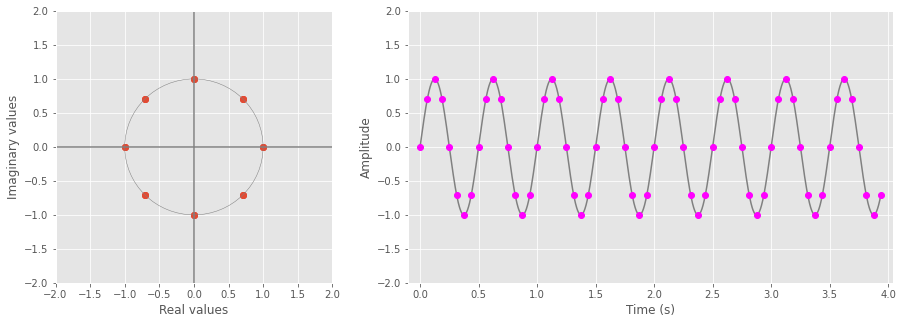

In [17]:
## Get our complex values corresponding to the phasor with frequency freq
zs, thetas, tsteps = gen_phasor_vals_freq(Tmin=Tmin, Tmax=Tmax, t_step=t_step, freq=freq)

## Project to real and imaginary parts for plotting
Xs = np.real(zs)
Ys = np.imag(zs)


## generate the background for the plot: a phasor diagram on the left, a time v amplitude graph on the right
fig, phasor, sinusoid = create_anim_bkg(tsteps, thetas, freq)

## the phasor (the complex sinusoid) is plotted on the left on the left with a circle with radius 1 for reference
phasor.set_xlabel("Real values")
phasor.set_ylabel("Imaginary values")
# plot the points the phasor will "step on"
phasor.scatter(Xs, Ys)

## Plot our actual sampled sine wave in magenta on the right
sinusoid.plot(tsteps, Ys, 'o', color='magenta')
sinusoid.set_xlabel("Time (s)")
sinusoid.set_ylabel("Amplitude")

You should see two graphs above:
* On the left is the complex sinusoid diagram: the grey circle represents a complex sinusoid (named `phasor` in the code) with magnitude 1, the red dots represents the points on the circle that are sampled from the complex sinusoid between `tmin` and `tmax` given the `sampling_rate`. 
* On the right is the time versus amplitude graph: The grey line shows a continuous sine wave with with frequency `freq`, the magenta dots show the points we actually sample between times `tmin` and `tmax` given the `sampling_rate`. 

You can see that although we sample 64 points for the sine wave, we actually just hit the same 8 values per cycle on the complex sinusoid. 

It's clearer when we animate it in time: 

In [18]:
## Now let's animate it! 
## a helper to draw the 'clockhand' line
X, Y, n_samples = get_line_coords(Xs, Ys)
## initialize the animation
line = phasor.plot([], [], color='b', lw=3)[0]
sin_t = sinusoid.plot([], [], 'o', color='b')[0]
figs = (line, sin_t)

anim = FuncAnimation(
    fig, lambda x: anim_sinusoid(x, X=X, Y=Y, tsteps=tsteps, figs=figs), interval=600, frames=n_samples)
 
HTML(anim.to_html5_video())



### Exercise 
Change the `freq` variable in the code below to investigate: 

* What happens when the sine wave frequency (cycles/second) `freq` is set to `sampling_rate/2`?
* What happens when the frequency `freq` approaches the half the `sampling_rate`? 
* What happens when the frequency `freq` equals the half the `sampling_rate`? 
* What happens when the frequency `freq` is greater than `sampling_rate/2`

freq=2.00 cycles/sec, sampling rate=16.00 samples/sec, sampling period=0.06 sec


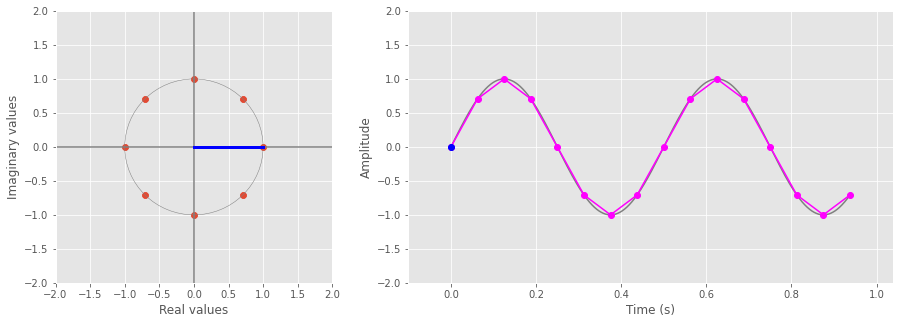

In [19]:
## Example: Play around with these values
Tmax = 1
Tmin = 0

freq = 2   # cycles/second
sampling_rate = 16 # f_s above
t_step=1/sampling_rate

print("freq=%.2f cycles/sec, sampling rate=%.2f samples/sec, sampling period=%.2f sec" % (freq, sampling_rate, t_step) )

## Get our complex values corresponding to the sine wave
zs, thetas, tsteps = gen_phasor_vals_freq(Tmin=Tmin, Tmax=Tmax, t_step=t_step, freq=freq)

## Project to real and imaginary parts for plotting
Xs = np.real(zs)
Ys = np.imag(zs)

## generate the background
fig, phasor, sinusoid = create_anim_bkg(tsteps, thetas, freq)

## Plot the phasor samples
phasor.scatter(Xs, Ys)
phasor.set_xlabel("Real values")
phasor.set_ylabel("Imaginary values")

## Plot our actual sampled sine wave in magenta
sinusoid.plot(tsteps, Ys, 'o-', color='magenta')
sinusoid.set_xlabel("Time (s)")
sinusoid.set_ylabel("Amplitude")

## Animate the phasor and sinusoid
X, Y, n_samples = get_line_coords(Xs, Ys)

line = phasor.plot([], [], color='b', lw=3)[0]
sin_t = sinusoid.plot([], [], 'o', color='b')[0]
figs = (line, sin_t)
anim = FuncAnimation(
    fig, lambda x: anim_sinusoid(x, X=X, Y=Y, tsteps=tsteps, figs=figs), interval=600, frames=n_samples)
 
HTML(anim.to_html5_video())


###  Notes


## Aliasing

If you change the frequency (`freq`) for the complex sinusoid to be higher than half the sampling rate, you'll see that the actual frequency  doesn't actually keep getting higher.  In fact, with `freq=8` the sine wave (i.e. projection of the vertical (imaginary) component) doesn't appear to have any amplitude modulation at all.  However, keen readers will note that for `sampling_rate=16` and `freq=8` in the example above, the real projection (i.e. cosine) would show amplitude modulations since $\cos(t)$ is 90 degree phase shifted relative to $\sin(t)$. The complex sinusoid with `freq=15` appears to complete only one cycle per second, just like for `freq=1`, but appears to rotating the opposite way.  

These are examples of **aliasing**: given a specific sampling rate there is a limit to which we can distinguish different frequencies because we simply can't take enough samples to show the difference! 

In the example above, even though we are sampling from a 15 Hz wave for `freq=15`, we only get one sample per cycle and the overall sampled sequence looks like a 1 Hz wave. So, the fact that the rotating vector appears to rotate the opposite way to `freq=1` is because it's actually just the 15th step of the `freq=1` sinusoid.  

<div class="alert alert-success">
In general, with a sampling rate of $f_s$ we can't distinguish between a sine wave of frequency $f_0$ and a sine wave of $f_0 + kf_s$ for any integer $k$.
</div>

This means that we can't actually tell the frequency of the underlying waveform based on the sample amplitudes alone. 

The practical upshot of this is that for sampling rate $f_s$, the highest frequency we can actually sample is $f_s/2$, the **Nyquist Frequency**.  This is one of the most important concepts in digital signal processing and will effect pretty much all the methods we use.  It's why we see the mirroring effect in [the DFT output spectrum](./signals-1-1-interpreting-the-discrete-fourier-transform.ipynb). So, if you remember just one thing, remember this! 



## Superposition

This use of complex sinusoids may seem excessively complex at the moment, but it actually gives us a nice way of visualizing what happens when we add two sine waves together, i.e. linear superposition.  

We've seen how the Fourier Transform gives us a way of breaking down periodic waveforms (no matter how complicated) into a linear combination of sinusoids (cosine waves, specifically).  But if you've seen the actual DFT equations, you'll have noticed that each DFT output is actually is described in terms of complex sinusoids of specific frequencies (e.g. sums over $e^{-j \theta}$ values).  We can now get at least a visual idea of what this means.

Let's look at how can combining complex sinusoids can let us define complicated waveforms in a simple manner. 


### Magnitude and Phase Modifications
First, let's note that we can easily change the magnitude and phase of a sine wave before adding it to others to make a complex waveform. 

* We can change the magnitude of a sinusoidal component by multiplying all the values of that sinusoid by a scalar $r$.

* We can apply a phase shift of $\phi$ radians to $\sin(\theta)$ to gives us a sine wave of the form: $\sin(\theta + \phi)$.  It basically means we start our cycles around the unit circle at $e^{i\phi}$ instead of at $e^{i0} = 1 + i0 \mapsto (1,0)$ 

### Generating linear combinations of sinusoids

Let's plot some combinations of sinusoids.

First let's set the sampling rate and the start and end times of the sequence we're going to generate:

In [20]:
## Some parameters to play with 
Tmax = 2
Tmin = 0

sampling_rate = 16
t_step=1/sampling_rate

Now, let's create some complex sinusoids with different magnitudes, frequencies and phases. Here we create 2 complex sinusoids with magnitude 1 and no phase shift, one with `freq=2` Hz and another  with frequency `2*freq`.  

We then add the two sinusoid values together at each timestep (`zs_sum` in the code below): 

In [21]:
## Define a bunch of sinusoids.  We can do this in terms of 3 parameters:  
## (magnitude, frequency, phase)

## The following defines two sinusoids, both with magnitude (peak amplitude) 1 and the same phase (no phase shift) 
## The second has double the frequency of the first:
freq=2
params = [(1, freq, 0), (1, 2*freq, 0)]  

## Later: change these values and see what happens, e.g. 
#params = [(1, freq, 0), (0.4, 5*freq, 0), (0.4, 5*freq, np.pi)]  

phasor_list = []
theta_list = []
tsteps_list = []

## Generate a list of complex sinusoids (phasors) for each set of (mag, freq, phase) parameters
for mag, freq, phase in params: 
    ## Generate a sinusoid with frequency freq
    ## zs are the complex sinusoid values
    ## thetas are the corresponding angles for each value in zs
    ## tsteps are the corresponding time steps for each value in zs
    zs, thetas, tsteps = gen_phasor_vals_freq(Tmin=Tmin, Tmax=Tmax, t_step=t_step, freq=freq) 
    
    ## Apply the phase_shift 
    phase_shift = np.exp(1j*phase)
    
    ## scale by the magnitude mag - changes the peak amplitude
    zs = mag*zs*phase_shift
    
    ## Append the phasor to a list
    phasor_list.append(zs)
    
    ## The angle sequence and time sequence in case you want to inspect them
    ## We don't actually use them below
    theta_list.append(thetas)
    tsteps_list.append(tsteps)

## Superposition: add the individual phasors in the list together (all with the same weights right now)
zs_sum = np.zeros(len(tsteps_list[0]))
for z in phasor_list: 
    zs_sum = zs_sum + z

Now, we can plot the sine (vertical) component of the individual sinusoids (on the right), ignoring the cosine (horizontal) component for the moment. 

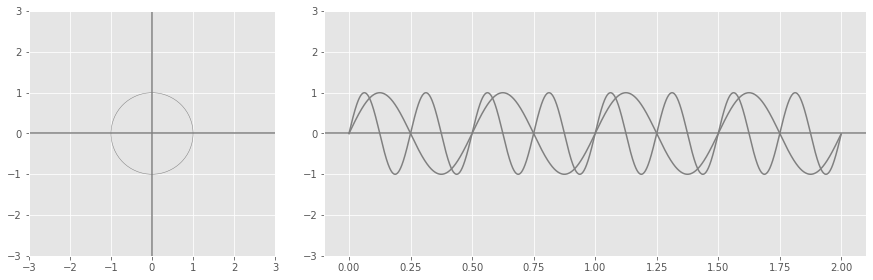

In [26]:
## Plot the complex sinusoid (left) and the projection of the imaginary (vertical) component (right)
## cosproj would be the projection to the real axis, but let's just ignore that for now

fig, phasor, sinproj, cosproj = create_phasor_sinusoid_bkg(Tmin, Tmax, ymax=3, plot_phasor=True, plot_real=False, plot_imag=True,)

dense_tstep=0.001
for mag, freq, phase in params:  
    ## We just want to plot the individual sinusoids (time v amplitude), so we ignore 
    ## the complex numbers we've been using to plot the phasors
    _, dense_thetas, dense_tsteps = gen_phasor_vals_freq(Tmin, Tmax, dense_tstep, freq)    
    sinproj.plot(dense_tsteps, mag*np.sin(dense_thetas+phase), color='grey')
    


Now plot the sum of the complex sinusoids (left) and the projected imaginary component in magenta (right) - that is, the sum of the sine components (in grey)

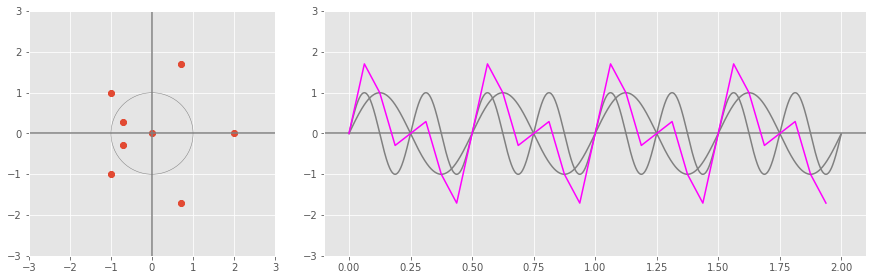

In [27]:
## Plot sinusoids as sampled
Xlist = []
Ylist = []

## some hacks to get to represent the individual phasors as lines from the centre of a circle as well as points
for i, zs in enumerate(phasor_list):
    Xs_ = np.real(zs)
    Ys_ = np.imag(zs)
    X_, Y_, _ = get_line_coords(Xs_, Ys_)
    Xlist.append(X_)
    Ylist.append(Y_)

## Project the real and imaginary parts of the timewise summed phasor values
Xs = np.real(zs_sum)
Ys = np.imag(zs_sum)
Xline, Yline, _ = get_line_coords(Xs, Ys)

## plot the summed phasor values as 2-d coordinates (left)
phasor.scatter(Xs, Ys)
## plot the sine projection of the phasor values in time (right)
sinproj.plot(tsteps_list[0], Ys, color='magenta')
fig

Now let's see an animation of how we're adding these complex sinusoids together! 

In [28]:
anim = get_phasor_animation(Xline, Yline, tsteps, phasor, sinproj, cosproj, fig, Xlist=Xlist, Ylist=Ylist, params=params)
anim

In the animation above you should see: 
* the red circle represents the first complex sinusoid (`freq=2`)
* the blue circle represents the 2nd complex sinusoid (`freq=4`)
* In adding the the two complex sinusoids together, we add the corresponding vectors for each complex sinusoid at each point in time. 

### Exercise:


* What happens when you add up two sinusoids with the same frequency but different magnitudes
    * e.g. `params = [(1, freq, 0), (2, freq, 0)]`
    
    
* What happens when you change the phase? 
    * Can you find $\phi$ such that $\sin(\theta+\phi) = \cos(\theta)$ ? 
    
    
* When do the individual sinusoids cancel each other out? 


* Assume you have a compound sinusoid defined by the following params: 
    * `params = [(1, freq, 0), (0.4, 5*freq, 0)]`  
    * What sinusoid could you add to cancel the higher frequency component out while keeping the lower frequency one? 


### Notes


## Maths Perspective: The DFT equation as a sum of complex sinusoids

Now if you look at the mathematical form of the DFT, you can start to recognize this as representing a sequence of complex sinusoids of different frequencies, which have a real (cosine) and imaginary (sine) component. 

The DFT is defined as follows:

* For input: $x[n]$, for $n=0..N-1$ (i.e. a time series of $N$ samples)
* We calculate an output of N complex numbers $\mapsto$ magnitude and phases of specific complex sinusoids:

Where the $k$th output, DFT[k], is calculated using the following equation: 
$$ 
\begin{align}
DFT[k] &= \sum_{n=0}^{N-1} x[n] e^{-j \frac{2\pi n}{N} k} \\
\end{align}
$$

Which is equivalent to the following (using Euler's rule):

$$
\begin{align}
DFT[k] &= \sum_{n=0}^{N-1} x[n]\big[\cos(\frac{2\pi n}{N} k) - j \sin(\frac{2\pi n}{N} k) \big] 
\end{align}
$$

This basically says that each DFT output is the result of multiplying the $n$th input value $x[n]$ with the $n$th sample of a complex sinusoid (hence sine and cosine waves) of a specific frequency, and summing the result (hence the complex number output). The frequency of DFT[k] is $k$ times the frequency of DFT[1], where the frequency of DFT[1] depends on the input size $N$ and the sampling rate (as discussed the [this notebook](./signals-1-1-interpreting-the-discrete-fourier-transform.ipynb)). The sampling rate determines the time each rotation step takes, hence how much time it takes to make a full cycle, hence what frequencies we can actually compare the input against.  

The pointwise multiplication and summation is also known as a dot product (aka inner product).  The dot product between two vectors tells us how similar those two vectors are. So in a very rough sense, the DFT 'figures out' which frequency components are present in the input, by looking at how similar the input is to each of the N complex sinusoids represented in the DFT output. 

There are two more notebooks on the DFT for this module, but both are extension material (not essential).

* [This notebook](./signals-1-3-discrete-fourier-transform-in-detail.ipynb) goes into more maths details but is purely extension material
* [This notebook](./signals-1-4-more-interpreting-the-dft.ipynb) looks at a few more issues in interpreting the DFT (also extension material)

So, you can look at those if you want more details. Otherwise, we'll move onto the source-filter model in the second signals lab! 
